In [523]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix

## Load the required modules
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, validation_curve, cross_val_score, GridSearchCV
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from tensorflow import keras
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.backend import clear_session

disable_eager_execution()

# Loading and Preparing the data


In [524]:
combined_y = pd.read_csv('utilization_rates_data/combined_final.csv')

dump_cols = ['day_of_week_num', 'hour', 'minutes', 'seconds', 'weektime_series',
            'useless', 'Unnamed: 0','Unnamed: 0_x', 'Unnamed: 0_y']
combined_y = combined_y.drop(dump_cols, axis=1)
combined_y = combined_y[(combined_y['address']!='388 9th St') & (combined_y['address']!='435 Hawthorne Ave')]


In [525]:
combined_y.sort_values(by='final_y', ascending=False)[['address', 'final_y', 'address']]

,address,final_y,address
40,101 Oyster Point Blvd,8.333333,101 Oyster Point Blvd
85,501 6th St,8.000000,501 6th St
63,2420 Ashby Ave,7.156342,2420 Ashby Ave
27,201 Gateway Blvd,6.000000,201 Gateway Blvd
34,Corporate Dr,6.000000,Corporate Dr
...,...,...,...
71,3300 College Dr,0.000000,3300 College Dr
72,333 El Camino Real,0.000000,333 El Camino Real
44,1260 Martin Luther King Jr Way,0.000000,1260 Martin Luther King Jr Way
17,333 E 8th St,0.000000,333 E 8th St


In [526]:
combined_y
## considere standarizing y columns and converting theem into tiers

,connection_type,power_kwh,power_kwh_num,address,latitude,longitude,available_denominator,available_numerator,availability_rate,utilization_rate,...,store,school,gym,local_government_office,entertainment,transit_station,place_of_worship,doctor,point_of_interest,establishment
0,CCS,29.8 kW,29.8,1103 Embarcadero,37.788209,-122.253026,1,0.979827,0.979827,0.020173,...,9,0,1,0,0,5,0,0,2,0
1,CCS,50 kW,50.0,1025 Gilman St,37.880724,-122.297818,2,1.532995,0.766497,0.233503,...,40,12,7,2,0,30,0,2,2,0
2,CCS,50 kW,50.0,1198 El Camino Real,37.555906,-122.318554,2,1.939210,0.969605,0.030395,...,8,11,4,0,0,4,0,5,2,0
3,CCS,50 kW,50.0,1227 Linda Mar Shopping Center,37.595175,-122.504069,2,1.857143,0.928571,0.071429,...,10,0,2,0,0,2,0,2,2,0
4,CCS,50 kW,50.0,230 Bay Pl,37.812769,-122.260998,4,3.349278,0.837320,0.162680,...,43,17,6,3,0,26,0,41,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,J1772,7.7 kW,7.7,5001 Junipero Serra Blvd,37.673841,-122.464239,2,1.021552,0.510776,0.489224,...,25,0,0,0,0,4,0,0,1,0
97,J1772,7.7 kW,7.7,523 Mulberry St,37.756594,-122.251475,2,0.482270,0.241135,0.758865,...,35,2,1,3,0,21,0,22,0,0
98,J1772,7.7 kW,7.7,5616 Bay St,37.834797,-122.291914,2,1.955882,0.977941,0.022059,...,27,0,0,2,0,11,0,1,1,0
99,J1772,7.7 kW,7.7,5795 Christie Ave,37.837864,-122.295603,2,1.367618,0.683809,0.316191,...,48,4,5,3,0,12,0,31,0,0


In [527]:
combined_y.columns

Index(['connection_type', 'power_kwh', 'power_kwh_num', 'address', 'latitude',
       'longitude', 'available_denominator', 'available_numerator',
       'availability_rate', 'utilization_rate', 'total_output_kwh', 'final_y',
       'lodging', 'supermarket', 'food', 'store', 'school', 'gym',
       'local_government_office', 'entertainment', 'transit_station',
       'place_of_worship', 'doctor', 'point_of_interest', 'establishment'],
      dtype='object')

In [528]:
X_train_cols = ['lodging', 'supermarket', 'food', 'store', 'school', 'gym',
       'local_government_office', 'entertainment', 'transit_station',
       'place_of_worship', 'doctor', 'point_of_interest', 'establishment']

X_train_full = combined_y[X_train_cols]
## y train can be adjusted as needed
y_col = 'power_kwh_num' # utilization_rate
y_train_full = combined_y[y_col]

## Stratified Sampling
X_train_sample, y_train_sample = resample(X_train_full,y_train_full,
                                          replace=False,n_samples=99,
                                          stratify=y_train_full,random_state=0)

ValueError: Unexpected kw arguments: dict_keys(['stratify'])

In [457]:
## Trainv-validation split 
X_train, X_test, y_train, y_test = train_test_split(X_train_sample, y_train_sample, test_size=0.2, random_state=0)



In [458]:
y_train_full.unique()

array([29.8 , 50.  , 62.5 , 40.5 ,  1.  , 16.6 ,  5.  ,  6.24,  6.7 ,
        7.2 ,  7.7 ])

(79, 13) (20, 13)


<AxesSubplot:xlabel='power_kwh_num'>

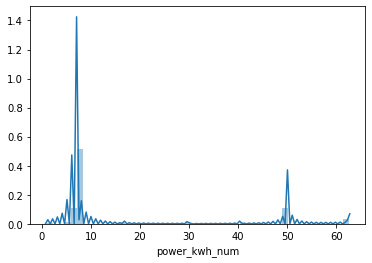

In [459]:
print(X_train.shape, X_test.shape)
sns.distplot(y_train_full)

In [460]:
combined_y[y_col].unique()

array([29.8 , 50.  , 62.5 , 40.5 ,  1.  , 16.6 ,  5.  ,  6.24,  6.7 ,
        7.2 ,  7.7 ])

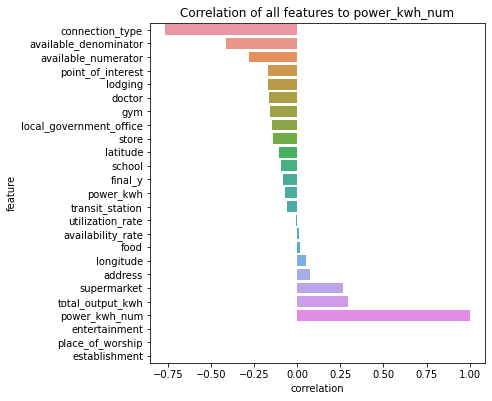

In [461]:
def corr_vis(df, features, meas='actual_voltage', rendered='spearman'):
    ## Create a blank dataframe that calculates all the correlations to TOG
    vis = pd.DataFrame()
    vis['feature'] = features
    corrs = ['spearman', 'kendall']
    for c in corrs:
        vis[c] = [df[f].corr(df[meas], c) for f in features]

    vis = vis.sort_values(rendered)
    plt.figure(figsize=(6, 0.25*len(features)))
    ax = sns.barplot(data=vis, y='feature', x=rendered, orient='h')
    
    ## Chart design
    ax.set(xlabel='correlation')
    ax.set(title='Correlation of all features to {meas}'.format(meas=meas)) 
    return vis

final_y_correlation_df = corr_vis(combined_y, combined_y.columns, meas=y_col)

# Models

In [462]:
comp = pd.DataFrame(y_train)
comp_test = comp_test = pd.DataFrame(y_test)
kf = StratifiedKFold(5,shuffle=True,random_state=0)

In [463]:
def plot_cv_curve(hyperparm_grid,train_scores,val_scores):
    '''
    from hw2
    '''
    ax = plt.subplot(111)
    ax.errorbar(hyperparm_grid,np.mean(train_scores,axis=1),yerr=np.std(train_scores,axis=1),label="train")
    ax.errorbar(hyperparm_grid,np.mean(val_scores,axis=1),yerr=np.std(val_scores,axis=1),label="validation")
    ax.set_xlabel('Hyperparameter')
    ax.set_ylabel('Score')
    ax.legend()
    ax.grid()
    return ax


## Linear Regression

In [464]:
reg_lm = LinearRegression()
reg_lm.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [465]:
comp['linear_reg_prediction'] = reg_lm.predict(X_train)
comp_test['linear_reg_prediction'] = reg_lm.predict(X_test)

In [466]:
lm_coefs = pd.DataFrame({'feature': X_train.columns, 'coefficient': reg_lm.coef_}).round(15)
pd.merge(left=final_y_correlation_df, right=lm_coefs, left_on='feature', right_on='feature', how='inner')

,feature,spearman,kendall,coefficient
0,point_of_interest,-0.168992,-0.149278,-6.378495e-01
1,lodging,-0.168157,-0.133221,-6.574474e-01
2,doctor,-0.164150,-0.123987,-2.497122e-01
3,gym,-0.156650,-0.122068,-9.552990e-01
4,local_government_office,-0.148519,-0.120082,9.081309e-02
5,store,-0.140584,-0.107914,-2.988933e-02
6,school,-0.091464,-0.067460,-4.613813e-02
7,transit_station,-0.058164,-0.042323,3.012792e-01
8,food,0.017266,0.016786,5.942144e-01
9,supermarket,0.265039,0.234708,4.041820e+00


In [467]:
squared_error = (comp['linear_reg_prediction']-comp['final_y'])**2
sns.regplot(x=comp['final_y'], y=squared_error)
plt.title('Training Squard Error for Linear Model')
plt.ylabel('Squared error')

KeyError: 'final_y'

In [ ]:
predicted = (comp['linear_reg_prediction'])
sns.regplot(x=comp['final_y'], y=predicted)
plt.title('Training Squard Error for Linear Model')

## Ridge Regression

In [468]:
ridge_model = Ridge(alpha=100, fit_intercept=True)
ridge_model.fit(X_train, y_train)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [469]:
ridge_train_error = mean_squared_error(y_train, ridge_model.predict(X_train))
print(ridge_train_error)

250.19946493662445


In [470]:
x_train_prime, x_valid, y_train_prime, y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=0)

In [471]:

alphas = 10 ** np.linspace(-3, 4, num=50, endpoint=True)

def model_ridge(x_train, y_train, x_valid, y_valid, alpha):
    ## initialize Ridge model using corresponding alpha and fit intercept
    m = Ridge(alpha=alpha, fit_intercept=True)
    
    ## Fit to the training data
    m.fit(x_train, y_train)
    
    ## predict on the validation data and calculate MSE
    return mean_squared_error(y_valid, m.predict(x_valid)) ## requires sklearn mean_squared_error


alpha_best = alphas[np.argmin([ model_ridge(x_train_prime, y_train_prime, x_valid, y_valid, a) for a in alphas])]
print(alpha_best)

719.6856730011514


In [472]:
optimized_ridge = Ridge(alpha=alpha_best, fit_intercept=True)
optimized_ridge.fit(X_train, y_train)

tuned_ridge_test_error = mean_squared_error(y_test, optimized_ridge.predict(X_test))
print(tuned_ridge_test_error)

415.8632714789818


In [473]:
comp['ridge_reg_prediction'] = optimized_ridge.predict(X_train)
comp_test['ridge_reg_prediction'] = optimized_ridge.predict(X_test)

In [476]:
squared_error = (comp['ridge_reg_prediction']-comp['final_y'])**2
sns.regplot(x=comp['final_y'], y=squared_error)
plt.title('Training Squard Error for Ridge Regression Model')
plt.ylabel('Squared error')

KeyError: 'final_y'

## Standardized Ridge Regression

In [477]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

x_train_prime, x_valid, y_train_prime, y_valid = train_test_split(X_train_std, y_train, test_size=0.10, random_state=0)

In [478]:

alphas = 10 ** np.linspace(-3, 4, num=50, endpoint=True)

def model_ridge(x_train, y_train, x_valid, y_valid, alpha):
    ## initialize Ridge model using corresponding alpha and fit intercept
    m = Ridge(alpha=alpha, fit_intercept=True)
    
    ## Fit to the training data
    m.fit(x_train, y_train)
    
    ## predict on the validation data and calculate MSE
    return mean_squared_error(y_valid, m.predict(x_valid)) ## requires sklearn mean_squared_error


alpha_best = alphas[np.argmin([ model_ridge(x_train_prime, y_train_prime, x_valid, y_valid, a) for a in alphas])]
print(alpha_best)

51.794746792312125


In [479]:
optimized_ridge = Ridge(alpha=alpha_best, fit_intercept=True)
optimized_ridge.fit(X_train_std, y_train)

tuned_ridge_test_error = mean_squared_error(y_test, optimized_ridge.predict(X_test_std))
print(tuned_ridge_test_error)

386.1302112232436


In [480]:
comp['std_ridge_reg_prediction'] = optimized_ridge.predict(X_train)
comp_test['std_ridge_reg_prediction'] = optimized_ridge.predict(X_test)

<AxesSubplot:xlabel='power_kwh_num'>

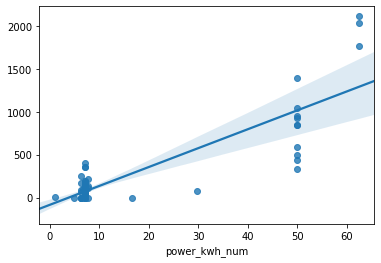

In [481]:
sns.regplot(data=comp, x=y_col, y=(comp['linear_reg_prediction']-comp[y_col])**2)

## Classification Models

In [503]:
y_train_classes = y_train.astype(str)
y_test_classes = y_test.astype(str)

In [504]:
len(X_train.columns)

13

### Logistic Regression

In [483]:
## Demo: training a default logit model and cross-validate

logit = LogisticRegression(max_iter=5000)
cv_scores = cross_val_score(logit,X_train,y_train_classes,cv=kf)
print ("Cross-Validation Accuracies:", cv_scores)
print ("Overall CV score is:", np.mean(cv_scores))

Cross-Validation Accuracies: [0.625      0.47619048 0.5        0.71428571 0.58333333]
Overall CV score is: 0.5797619047619048


Wall time for training & cross-validation: 10.761895461997483 second


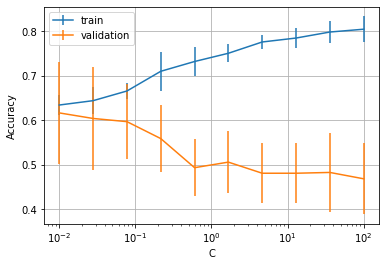

In [484]:
C_grid = np.logspace(-2,2,10)

time_start = timer()

## ran under 20 seconds which is fast
## build a 10x5(mxn) tall grid
m = kf.get_n_splits()
n = len(C_grid)
train_scores = [[0 for garbo_j in range(m)] for garbo_i in range(n)]
val_scores = [[0 for garbo_j in range(m)] for garbo_i in range(n)]

## Split using the KFold to grab the train and validation indices
i=0
for train_index, valid_index in kf.split(X_train, y_train_classes):
    ## Use indices to find training and validation data
    X_train_train, X_train_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_train, y_train_valid = y_train_classes.iloc[train_index], y_train_classes.iloc[valid_index]
    
    for j in range(len(C_grid)):
        ## Initialize the Logistic Regression model with appropriate params and fit to training training data
        temp_logit = LogisticRegression(max_iter=5000, C=C_grid[j], solver='newton-cg').fit(X_train_train, y_train_train)
        
        ## Calculate training and validation scores and add scores to building list
        train_scores[j][i] = temp_logit.score(X_train_train, y_train_train)
        val_scores[j][i] = temp_logit.score(X_train_valid, y_train_valid)
#         print("filled i,j", i,j)
    
    i+=1
    
time_end = timer()

print ("Wall time for training & cross-validation: {0} second".format(time_end-time_start))

ax = plot_cv_curve(C_grid,train_scores,val_scores)
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
ax.set_xscale('log')

In [485]:
best_logit = LogisticRegression(max_iter=5000, C=3*10**-2, solver='newton-cg').fit(X_train, y_train_classes)

In [486]:
comp['logit_reg_prediction'] = best_logit.predict(X_train)
comp_test['logit_reg_prediction'] = best_logit.predict(X_test)

### Linear SVM

Wall time for training & cross-validation: 0.5502791090038954 second


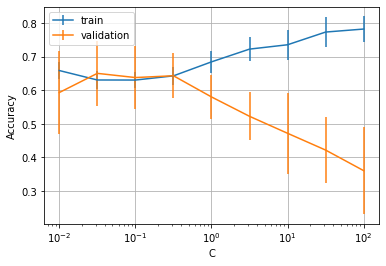

In [487]:
C_grid = np.logspace(-2,2,9)
## Your code here

time_start = timer()

## build a 9x5(mxn) tall grid
m = kf.get_n_splits()
n = len(C_grid)
train_scores = [[0 for garbo_j in range(m)] for garbo_i in range(n)]
val_scores = [[0 for garbo_j in range(m)] for garbo_i in range(n)]

## Split using the KFold to grab the train and validation indices
i=0
for train_index, valid_index in kf.split(X_train, y_train_classes):
    ## Initialize and it a scaler
    scaler = StandardScaler()
    scaler.fit(X_train.iloc[train_index])
    
    ## Use indices to find training and validation data
    X_train_train, X_train_valid = scaler.transform(X_train.iloc[train_index]), scaler.transform(X_train.iloc[valid_index])
    y_train_train, y_train_valid = y_train_classes.iloc[train_index], y_train_classes.iloc[valid_index]
    
    
    
    for j in range(len(C_grid)):
        ## Initialize the Linear SVC model with appropriate params and fit to training training data
        lsvc = LinearSVC(C=C_grid[j], loss='hinge', max_iter=20000).fit(X_train_train, y_train_train)
        
        ## Calculate training and validation scores and add scores to building list
        train_scores[j][i] = lsvc.score(X_train_train, y_train_train)
        val_scores[j][i] = lsvc.score(X_train_valid, y_train_valid)
#         print("filled i,j", i,j)
    
    i+=1

time_end = timer()

print ("Wall time for training & cross-validation: {0} second".format(time_end-time_start))


ax = plot_cv_curve(C_grid,train_scores,val_scores)
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
ax.set_xscale('log')

In [488]:
## Example: declare a pipeline with only one stage SVC() named 'svc' with rbf kernel
## You can overwrite clf_svm_rbf with your own classifier
# clf_svm_rbf = Pipeline([('svc', SVC(kernel='rbf'))])

linear_svm = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC(loss='hinge', C=7*10**-1))])
linear_svm.fit(X_train, y_train_classes)


print ("Final SVM Hyperparameters:")
print (linear_svm.named_steps['svc'] if linear_svm.__class__==Pipeline else linear_svm)
print ("Overall CV score is:", np.mean(cross_val_score(linear_svm,X_train,y_train_classes,cv=kf)))
print ("Test Accuracy is:", metrics.accuracy_score(y_test_classes,linear_svm.predict(X_test)))

Final SVM Hyperparameters:
LinearSVC(C=0.7000000000000001, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Overall CV score is: 0.5946428571428571
Test Accuracy is: 0.45


In [489]:
comp['linear_svm_prediction'] = linear_svm.predict(X_train)
comp_test['linear_svm_prediction'] = linear_svm.predict(X_test)

## RBF SVM

In [490]:
## Example: declare a pipeline with only one stage SVC() named 'svc' with rbf kernel
## You can overwrite clf_svm_rbf with your own classifier
# clf_svm_rbf = Pipeline([('svc', SVC(kernel='rbf'))])

## Your code here
clf_svm_rbf = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=1))])
clf_svm_rbf.fit(X_train, y_train_classes)


print ("Final SVM Hyperparameters:")
print (clf_svm_rbf.named_steps['svc'] if clf_svm_rbf.__class__==Pipeline else clf_svm_rbf)
print ("Overall CV score is:", np.mean(cross_val_score(clf_svm_rbf,X_train,y_train_classes,cv=kf)))
print ("Test Accuracy is:", metrics.accuracy_score(y_test_classes,clf_svm_rbf.predict(X_test)))

Final SVM Hyperparameters:
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Overall CV score is: 0.6380952380952382
Test Accuracy is: 0.45


In [491]:
comp['svm_rbf_prediction'] = clf_svm_rbf.predict(X_train)
comp_test['svm_rbf_prediction'] = clf_svm_rbf.predict(X_test)

### Poly SVM

In [492]:
## Your code here
C_grid = np.linspace(5,15,51)
best_test = 0
best_train = 0
best_c = -1
for c in C_grid:
    clf_svm_poly = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='poly', C=c, degree=1))])
    clf_svm_poly.fit(X_train, y_train_classes)
    #print(c)
    #print ("Overall CV score is:", np.mean(cross_val_score(clf_svm_poly,X_train,y_train,cv=kf)))
    acc = metrics.accuracy_score(y_test_classes,clf_svm_poly.predict(X_test))
    #print ("Test Accuracy is:", acc)
    if acc > best_test:
        best_test = acc
        best_train = np.mean(cross_val_score(clf_svm_poly,X_train,y_train_classes,cv=kf))
        best_c=c


In [493]:
print('BEST: ',best_c, " >> ", best_test)

BEST:  5.0  >>  0.4


In [494]:
## Your code here
clf_svm_poly = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='poly', C=best_c, degree=1))])
clf_svm_poly.fit(X_train, y_train_classes)

print ("Final SVM Hyperparameters:")
print (clf_svm_poly.named_steps['svc'] if clf_svm_poly.__class__==Pipeline else clf_svm_poly)
print ("Overall CV score is:", np.mean(cross_val_score(clf_svm_poly,X_train,y_train_classes,cv=kf)))
print ("Test Accuracy is:", metrics.accuracy_score(y_test_classes,clf_svm_poly.predict(X_test)))

Final SVM Hyperparameters:
SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Overall CV score is: 0.6142857142857143
Test Accuracy is: 0.4


In [495]:
comp['clf_svm_poly_prediction'] = clf_svm_poly.predict(X_train)
comp_test['clf_svm_poly_prediction'] = clf_svm_poly.predict(X_test)


In [496]:
def display_accuracies(comp_df, comp_test_df, cols, y='power_kwh_num'):
    for c in cols:
        
        train_wrong = comp_df[comp_df[y]!=pd.to_numeric(comp_df[c])]
        train_correct =  comp_df[comp_df[y]==pd.to_numeric(comp_df[c])]
        
        test_wrong = comp_test_df[comp_test_df[y]!=pd.to_numeric(comp_test_df[c])]
        test_correct =  comp_test_df[comp_test_df[y]==pd.to_numeric(comp_test_df[c])]
        print("Incorrect training count: ", len(train_wrong))
        print("  Correct training count: ", len(train_correct))
        print("Incorrect test count: ", len(test_wrong))
        print("  Correct test count: ", len(test_correct))
        print('\n', c)
        print('  > Train Accuracy: ',  len(train_correct)/len(comp_df))
        print('  > Test Accuracy : ',  len(test_correct)/len(comp_test_df))

In [505]:
comp.head()

,power_kwh_num,linear_reg_prediction,ridge_reg_prediction,std_ridge_reg_prediction,logit_reg_prediction,linear_svm_prediction,svm_rbf_prediction,clf_svm_poly_prediction
43,7.2,12.963719,15.742359,84.991358,7.2,7.2,7.2,7.2
62,7.2,17.709786,17.603744,106.111373,7.2,7.2,7.2,7.2
3,50.0,17.736140,16.353067,94.104731,7.2,7.2,7.2,7.2
71,7.2,6.506983,9.799214,74.040887,7.2,7.2,7.2,7.2
45,7.2,13.607420,16.439531,88.623591,7.2,7.2,7.2,7.2


In [508]:
comp[comp['power_kwh_num']==5]

,power_kwh_num,linear_reg_prediction,ridge_reg_prediction,std_ridge_reg_prediction,logit_reg_prediction,linear_svm_prediction,svm_rbf_prediction,clf_svm_poly_prediction
21,5.0,5.610158,11.422206,-4.172246,7.2,7.2,7.2,7.2


In [498]:
#sns.scatterplot(data=comp, x='final_y', y='linear_reg_prediction')

In [499]:
comparable_cols = ['logit_reg_prediction', 'clf_svm_poly_prediction', 'clf_dt_prediction',
       'clf_rf_prediction', 'clf_ab_prediction', 'svm_rbf_prediction']
comparable_cols = ['logit_reg_prediction', 'linear_svm_prediction',
                   'svm_rbf_prediction','clf_svm_poly_prediction']

display_accuracies(comp, comp_test, comparable_cols)

Incorrect training count:  28
  Correct training count:  51
Incorrect test count:  11
  Correct test count:  9

 logit_reg_prediction
  > Train Accuracy:  0.6455696202531646
  > Test Accuracy :  0.45
Incorrect training count:  26
  Correct training count:  53
Incorrect test count:  11
  Correct test count:  9

 linear_svm_prediction
  > Train Accuracy:  0.6708860759493671
  > Test Accuracy :  0.45
Incorrect training count:  30
  Correct training count:  49
Incorrect test count:  11
  Correct test count:  9

 svm_rbf_prediction
  > Train Accuracy:  0.620253164556962
  > Test Accuracy :  0.45
Incorrect training count:  26
  Correct training count:  53
Incorrect test count:  12
  Correct test count:  8

 clf_svm_poly_prediction
  > Train Accuracy:  0.6708860759493671
  > Test Accuracy :  0.4


In [500]:
labels = comp['power_kwh_num'].astype(str).unique()

mod = 'clf_svm_poly_prediction'
logit_reg_cm = confusion_matrix(comp['power_kwh_num'].astype(str), comp[mod].astype(str), labels=labels)

Text(0.5, 1.0, 'Confusion martix of Polynomial SVM Model\nacross all charger types by output power (kwh)')

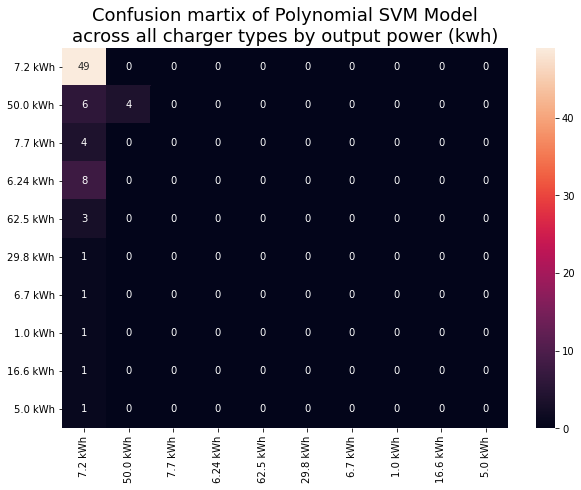

In [414]:
str_labels = comp['power_kwh_num'].astype(str).unique()
df_cm = pd.DataFrame(logit_reg_cm, index = [i + " kWh" for i in labels],
                  columns = [i+ " kWh" for i in labels])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion martix of Polynomial SVM Model\nacross all charger types by output power (kwh)', size=18)

In [406]:
combined_y['power_kwh'].unique()

array(['29.8 kW', '50 kW', '62.5 kW', '40.5 kW', '1 kW', '16.6 kW',
       '5 kW', '6.24 kW', '6.7 kW', '7.2 kW', '7.7 kW'], dtype=object)